# Executive Summary
A process to extract LiDAR data from an AWS s3 bucket is showcased. Although this public data has missing values, this process includes an interpolation section were those missing values are approximated using surrounded values.
This data can then be used with Aerial Imagery, Flood Maps and Forestry Maps to provide insights and make predictions.

In [1]:
import pdal
import json
import numpy.ma as ma
import numpy as np
import pandas as pd
import rasterio as rs
from rasterio.fill import fillnodata
from matplotlib import pyplot as plt
from scipy.interpolate import griddata

In [2]:
print("PDAL",pdal.__version__)
print("JSON",json.__version__)
print("Numpy",np.__version__)
print("Pandas",pd.__version__)
print("RasterIO",rs.__version__)

PDAL 3.2.0
JSON 2.0.9
Numpy 1.21.6
Pandas 1.3.5
RasterIO 1.2.10


In [2]:
#Data conditions for LiDAR layer acquisition
json_string={
    "pipeline": [
        {
"bounds": "([-10425171.940, -10423171.940], [5164494.710, 5166494.710])",
"filename": "https://s3-us-west-2.amazonaws.com/usgs-lidar-public/IA_FullState/ept.json",
"type": "readers.ept",
"tag": "readdata"
        },
        {
            "limits": "Classification![7:7]",
            "type": "filters.range",
            "tag": "nonoise"
        },
        {
            "assignment": "Classification[:]=0",
            "tag": "wipeclasses",
            "type": "filters.assign"
        },
        {
            "out_srs": "EPSG:26915",
            "tag": "reprojectUTM",
            "type": "filters.reprojection"
        },
        {
            "tag": "groundify",
            "type": "filters.smrf"
        },
        {
            "limits": "Classification[2:2]",
            "type": "filters.range",
            "tag": "classify"
        },
        {
            "filename": "iowa.laz",
            "inputs": [ "classify" ],
            "tag": "writerslas",
            "type": "writers.las"
        },
        {
            "filename": "iowa.tif",
            "gdalopts": "tiled=yes,     compress=deflate",
            "inputs": [ "writerslas" ],
            "nodata": 0,
            "output_type": "idw",
            "resolution": 1,
            "type": "writers.gdal",
            "window_size": 6
        }
    ]
}

In [3]:
jsonString = json.dumps(json_string)
jsonFile = open("iowa.json", "w")
jsonFile.write(jsonString)
jsonFile.close()

In [4]:
#Data acquisition from s3 bucket
! pdal pipeline iowa.json

In [5]:
name="iowa.tif"
im=rs.open('./'+name)

In [6]:
#Display Raster File Specifics
print(im.count)
print(im.height,im.width)
print(im.crs)

1
1493 1499
EPSG:26915


In [7]:
print(im.bounds)

BoundingBox(left=446112.3908587211, bottom=4652575.192733061, right=447611.3908587211, top=4654068.192733061)


In [8]:
im.tags(ns='IMAGE_STRUCTURE')

{'COMPRESSION': 'DEFLATE', 'INTERLEAVE': 'BAND'}

In [9]:
print(im.meta)

{'driver': 'GTiff', 'dtype': 'float64', 'nodata': 0.0, 'width': 1499, 'height': 1493, 'count': 1, 'crs': CRS.from_epsg(26915), 'transform': Affine(1.0, 0.0, 446112.3908587211,
       0.0, -1.0, 4654068.192733061)}


In [10]:
im.crs.wkt

'PROJCS["NAD83 / UTM zone 15N",GEOGCS["NAD83",DATUM["North_American_Datum_1983",SPHEROID["GRS 1980",6378137,298.257222101,AUTHORITY["EPSG","7019"]],AUTHORITY["EPSG","6269"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4269"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",0],PARAMETER["central_meridian",-93],PARAMETER["scale_factor",0.9996],PARAMETER["false_easting",500000],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","26915"]]'

In [11]:
#Reading Raster File and Displaying Max and Min Values
read=im.read()
print(np.min(read))
print(round(np.min(ma.masked_array(read,mask=read==0))))
print(round(np.max(read)))

0.0
270
318


In [12]:
#Shape of Raster File
read.shape

(1, 1493, 1499)

In [13]:
#Convert Raster File into Dataframe, and Drop NAs for Interpolated Values 
n_read=pd.DataFrame(read.copy().reshape([read.shape[1],read.shape[2]]))
n_read=np.array(n_read,dtype="int8")
mask=np.array(n_read!=0)
n_fill=fillnodata(read,mask=mask,max_search_distance=20,smoothing_iterations=1000)
n_fill=pd.DataFrame(n_fill.reshape([n_fill.shape[1],n_fill.shape[2]]))

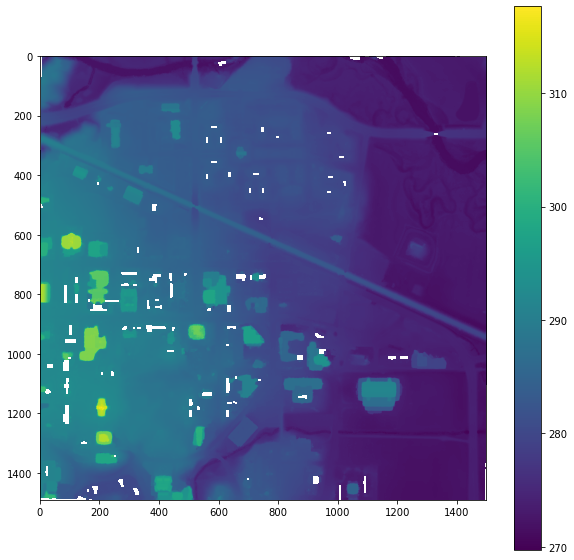

In [14]:
#Visualize Dataframe, Displays areas where NAs are located (White)
plt.figure(figsize=(10,10))
plt.imshow(n_fill)
plt.colorbar()

In [15]:
%%time
#While loop to fill in missing values
while n_fill.isnull().sum().sum()>0:
    n_read=pd.DataFrame(read.copy().reshape([read.shape[1],read.shape[2]]))
    n_read=np.array(n_read,dtype="int8")
    mask=np.array(n_read!=0)
    n_fill=fillnodata(read,mask=mask,max_search_distance=20,smoothing_iterations=1000)
    n_fill=pd.DataFrame(n_fill.reshape([n_fill.shape[1],n_fill.shape[2]]))
    print(n_fill.isnull().sum().sum())

4407
2102
993
488
214
57
12
0
CPU times: user 35.7 s, sys: 458 ms, total: 36.1 s
Wall time: 36.3 s


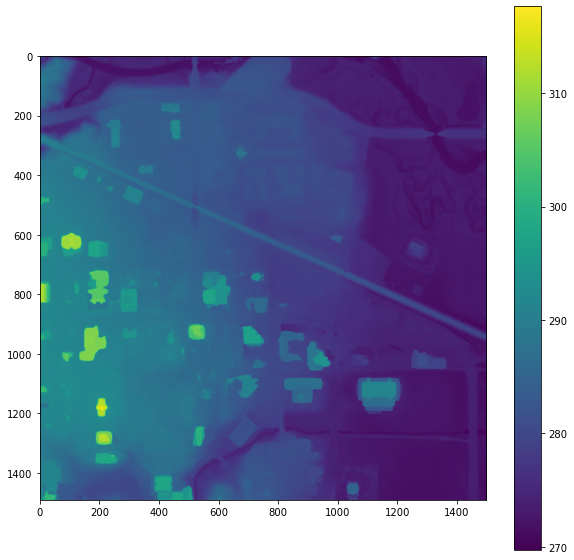

In [16]:
#Visualize Dataframe with Interpolated Values
plt.figure(figsize=(10,10))
plt.imshow(n_fill)
plt.colorbar()

In [17]:
#Displaying Max and Min Values
print(round(np.min(np.array(n_fill))))
print(round(np.max(np.array(n_fill))))

270
318
